In [1]:
import torch
import torchvision
from torchvision import transforms, utils, models
from torch.utils.data import DataLoader

import psycopg2,datetime,heapq

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import os
import shutil

from sklearn.manifold import TSNE

import seaborn as sns



In [118]:

conn = psycopg2.connect(database="trademark1", user="tm_root", password="roottm_9823a", host="trueint.lu.im.ntu.edu.tw", port="5433")
cur = conn.cursor()

In [119]:
%%time
caseno_list = []
cur.execute("SELECT trademark.caseno, trademark.doc, trademark.Trademark_Design, rcc.Class, rcp.FileName, rcc.goods_denomination \
            FROM trademark  INNER JOIN  rcc ON (trademark.caseno = rcc.caseno) \
             INNER JOIN rcp ON ( trademark.caseno = rcp.caseno  ) \
where (doc='TrademarkRegXMLB_048005' or doc='TrademarkRegXMLB_048004' or doc='TrademarkRegXMLB_048003' \
        or doc='TrademarkRegXMLB_048002' or doc='TrademarkRegXMLB_048001' \
        or doc='TrademarkRegXMLB_047024' or doc='TrademarkRegXMLB_047023' or doc='TrademarkRegXMLB_047022' \
        or doc='TrademarkRegXMLB_047021' or doc='TrademarkRegXMLB_047020' or doc='TrademarkRegXMLB_047019' \
        or doc='TrademarkRegXMLB_047018' or doc='TrademarkRegXMLB_047017' or doc='TrademarkRegXMLB_047016')\
        ")
r = cur.fetchall()


CPU times: user 105 ms, sys: 8.13 ms, total: 113 ms
Wall time: 319 ms


In [120]:
caseno_list += [i for i in r]
len(caseno_list)

62355

In [121]:
data = pd.DataFrame(caseno_list, columns=['caseno', 'doc', 'design', 'class', 'filename','goods_denomination'])
data['path'] = '/service/trademark/raw_data/XMLB/' + data.doc+ '/' + data.filename
data.dropna(inplace=True)



In [122]:
data.design.value_counts()

(墨色)(平面)    50083
(彩色)(平面)    11950
(彩色)(立體)      202
(墨色)(立體)       64
(墨色)(其他)       12
Name: design, dtype: int64

In [123]:
data = data[data.design=='(彩色)(平面)']

In [75]:
# %%time
# os.mkdir('./img_representaion')
# for i in range(1,46):
#     os.mkdir('./img_representaion/' + str(i))

# for i, j, k in zip(data['filename'], data['path'], data['class']):
# #     im = Image.open(j)
# #     im.save('./img_representaion/{}/'.format(int(k))  +i.split('/')[1])
# #     display(im)
# #     print(j)
#       shutil.copy(j, './img_representaion/{}/'.format(int(k))  +i.split('/')[1])

CPU times: user 419 ms, sys: 428 ms, total: 847 ms
Wall time: 1.22 s


In [125]:
# data.to_csv('img_index.csv', index=False)


In [23]:
# !export TESSDATA_PREFIX=/usr/share/tesseract-ocr/4.00/tessdata

In [76]:
# Image.open()

import cv2
import pytesseract

image = cv2.imread('/service/trademark/raw_data/XMLB/TrademarkRegXMLB_047016/imagesdata/egimg_108062634_1_047016.jpg')
text = pytesseract.image_to_string(image)
print(text)

On



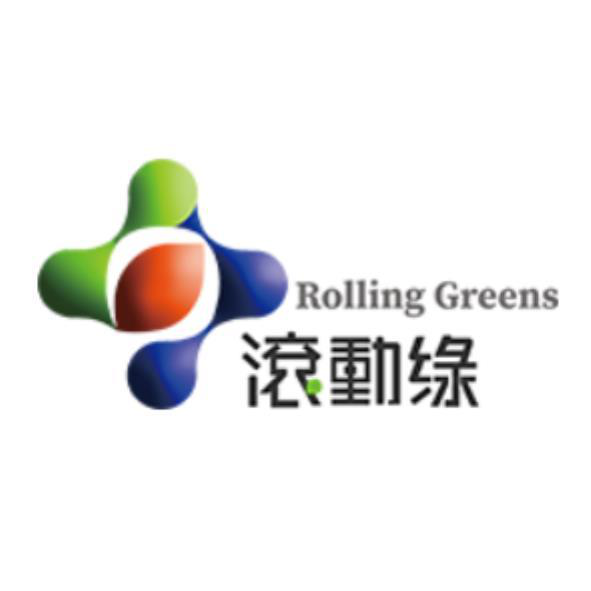

In [77]:
Image.open('/service/trademark/raw_data/XMLB/TrademarkRegXMLB_047016/imagesdata/egimg_108062634_1_047016.jpg')

## Load image

In [149]:
img_data = torchvision.datasets.ImageFolder('./img_representaion',
transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
                                            )

In [150]:
data_loader = torch.utils.data.DataLoader(img_data, batch_size=300,shuffle=False)
print(len(data_loader))

40


In [51]:
# def show_batch(imgs):
#     grid = utils.make_grid(imgs)
#     plt.imshow(grid.numpy().transpose((1, 2, 0)))
#     plt.title('Batch from dataloader')

In [2]:
# for i, (batch_x, batch_y) in enumerate(data_loader):
#     if(i<4):
#         print(i, batch_x.size(),batch_y.size())
#         show_batch(batch_x)
#         plt.axis('off')
#         plt.show()
#     else:
#          break

In [190]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval()
model.training

False

In [191]:
model.to(device)
model.training

False

In [194]:
%%time
img_vectors = []
with torch.no_grad():
    for i, (x, y) in enumerate(data_loader):
        x = x.to(device)
        out = model(x).cpu()
        out = torch.squeeze(out)
        out = out.numpy()
        y = y.numpy().reshape(-1,1)+1
        
#         print(np.concatenate((out, y), axis=1))
#         print(out.shape)
#         break
        img_vectors.append(np.concatenate((out, y), axis=1))
        # if i % == 0:
        print(i*data_loader.batch_size, end='/')
        
        

0/300/600/900/1200/1500/1800/2100/2400/2700/3000/3300/3600/3900/4200/4500/4800/5100/5400/5700/6000/6300/6600/6900/7200/7500/7800/8100/8400/8700/9000/9300/9600/9900/10200/10500/10800/11100/11400/11700/CPU times: user 7min 22s, sys: 7.73 s, total: 7min 29s
Wall time: 1min 33s


In [195]:
# img_vectors = np.vstack(img_vectors)

In [197]:
# np.savetxt('./img_vectors.csv', img_vectors[:, :-1], delimiter=',')
# np.savetxt('./img_class.csv', img_vectors[:,-1], delimiter=',')

In [3]:
img_vectors = np.genfromtxt('./img_vectors.csv', delimiter=',')
classlist = np.genfromtxt('./img_class.csv', delimiter=',')

In [4]:
img_vectors.shape

(11950, 2048)

In [5]:
data = pd.read_csv('img_index.csv')

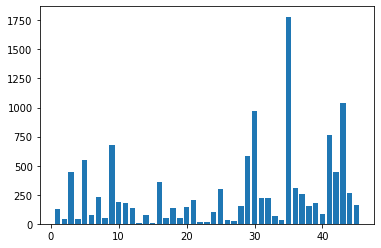

In [6]:

plt.bar(x=data['class'].value_counts().index, height = data['class'].value_counts().values)
plt.show()

## t-SNE

In [12]:
plt.style.use('default')

In [203]:
# %%time
# tsne_vec_euc = TSNE(n_components=2,  metric='euclidean',n_jobs=-1, perplexity=45).fit_transform(img_vectors)
# np.savetxt('./tsne_vec_euc.csv',tsne_vec_euc, delimiter=',')

CPU times: user 12min 50s, sys: 311 ms, total: 12min 50s
Wall time: 2min 17s


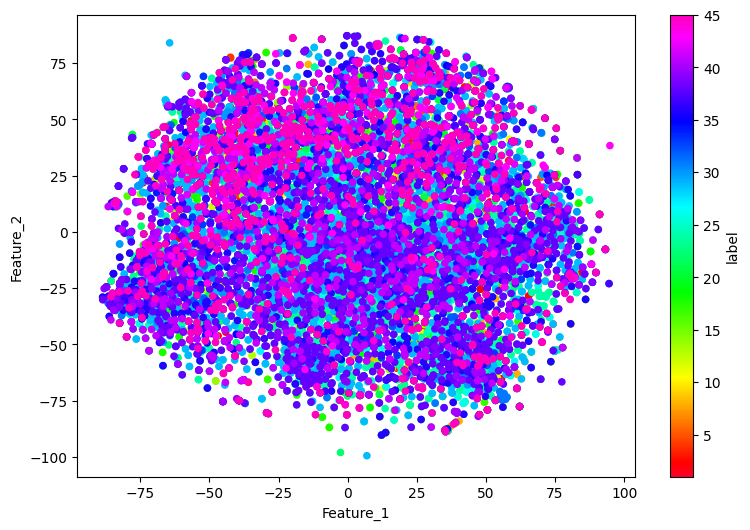

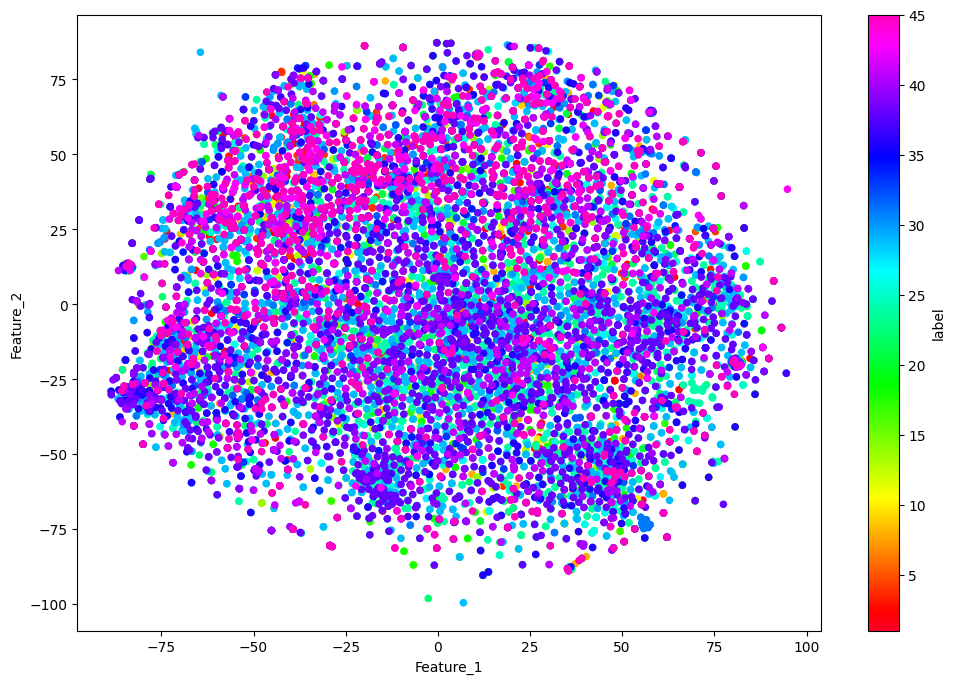

In [13]:
tsne_vec_euc = np.genfromtxt('./tsne_vec_euc.csv', delimiter=',')
df = pd.DataFrame(dict(Feature_1=tsne_vec_euc[:,0], Feature_2=tsne_vec_euc[:,1], label=classlist))
df.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='gist_rainbow', figsize=(9,6))
df.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='gist_rainbow', figsize=(12,8))
plt.show()

In [14]:
# %%time
# tsne_vec_cos = TSNE(n_components=2,  metric='cosine',n_jobs=-1, perplexity=45).fit_transform(img_vectors)
# np.savetxt('./tsne_vec_cos.csv',tsne_vec_cos, delimiter=',')

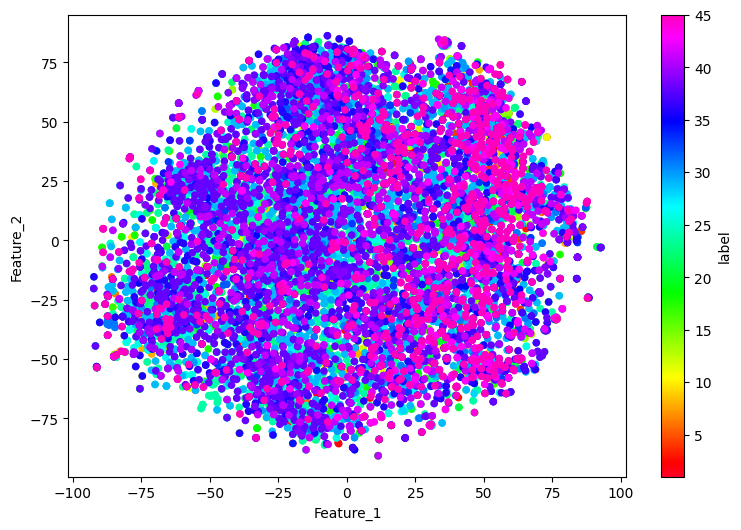

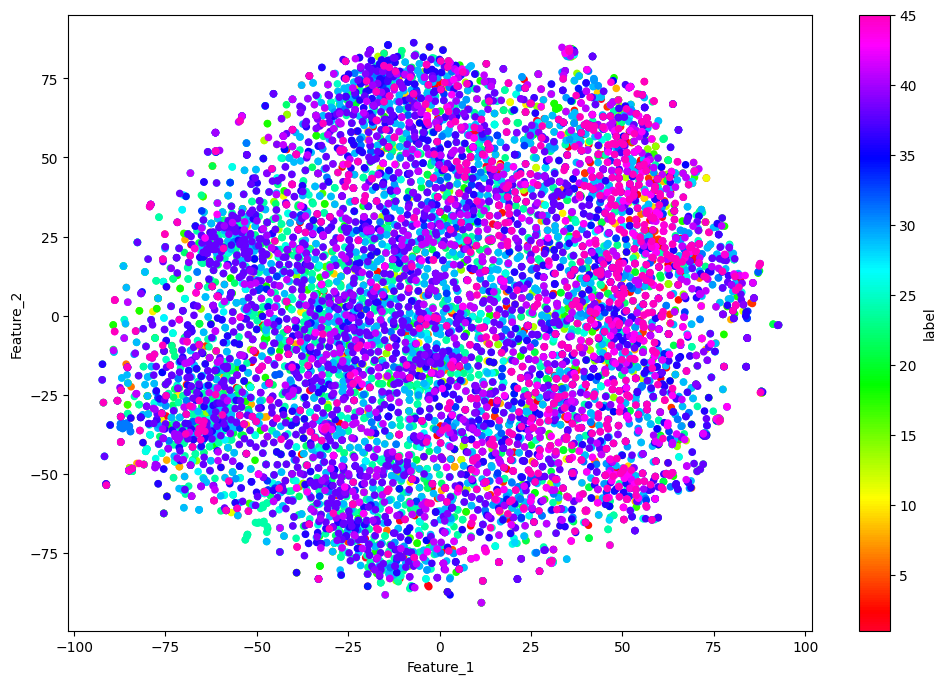

In [15]:
tsne_vec_cos = np.genfromtxt('./tsne_vec_cos.csv', delimiter=',')
df = pd.DataFrame(dict(Feature_1=tsne_vec_cos[:,0], Feature_2=tsne_vec_cos[:,1], label=classlist))
df.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='gist_rainbow', figsize=(9,6))
df.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='gist_rainbow', figsize=(12,8))
plt.show()